In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PINN(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for solving the 1D Gross–Pitaevskii equation.

    This network consists of 3 hidden layers with 'tanh' activation and an output layer
    that produces a single solution value `u(x)` without activation.

    Attributes
    ----------
    hidden_layers : nn.ModuleList
        List of three linear layers with 32 units each and 'tanh' activation.
    output_layer : nn.Linear
        Output layer with a single unit and no activation.
    """

    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(1, 32), nn.Linear(32, 32), nn.Linear(32, 32)])
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        """
        Forward pass through the network.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor containing spatial points.

        Returns
        -------
        torch.Tensor
            Output tensor representing the predicted solution `u(x)`.
        """
        for layer in self.hidden_layers:
            x = torch.tanh(layer(x))
        return self.output_layer(x)


def rayleigh_quotient(model, x, eta, u, u_x):
    """
    Computes the Rayleigh quotient for the given model output to estimate the eigenvalue.

    Parameters
    ----------
    model : PINN
        The PINN model used for approximating the solution.
    x : torch.Tensor
        Input tensor for which to compute the Rayleigh quotient.
    eta : float
        Nonlinearity parameter for the equation.
    u : torch.Tensor
        Model output for the given input.
    u_x : torch.Tensor
        First derivative of the model output with respect to the input.

    Returns
    -------
    torch.Tensor
        The Rayleigh quotient, an estimate of the eigenvalue.
    """
    numerator = torch.mean(u_x**2 + 0.5 * eta * u**4)
    denominator = torch.mean(u**2)
    return numerator / denominator


def compute_loss(model, x, eta, B, N):
    """
    Compute the total loss, including Rayleigh quotient, boundary, normalization, and PDE residual losses.

    Parameters
    ----------
    model : PINN
        The PINN model for solving the equation.
    x : torch.Tensor
        Input tensor for computing the loss.
    eta : float
        Nonlinearity parameter for the equation.
    B : float
        Weighting factor for the boundary loss.
    N : float
        Weighting factor for the normalization loss.

    Returns
    -------
    tuple of torch.Tensor
        The total loss and Rayleigh quotient loss.
    """
    x.requires_grad_(True)
    u = model(x)   # Predict u(x)
    u_x = grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

    rayleigh_loss = rayleigh_quotient(model, x, eta, u, u_x)
    boundary_loss = torch.mean((model(torch.tensor([[0.0], [1.0]], device=device)) - 0.0)**2)
    norm_loss = (torch.mean(u**2) - 1.0)**2

    # PDE residual: d²u/dx² + η * u^4 + λu = 0
    residual = u_xx + eta * u**4 + rayleigh_loss * u
    pde_loss = torch.mean(residual**2)

    total_loss = rayleigh_loss + B * boundary_loss + N * norm_loss + pde_loss
    return total_loss, rayleigh_loss


def train_model(model, x_train, epochs, optimizer, eta, B, N):
    """
    Trains the PINN model to solve the 1D Gross–Pitaevskii equation.

    Parameters
    ----------
    model : PINN
        The PINN model to be trained.
    x_train : torch.Tensor
        Training data points in the domain [0, 1].
    epochs : int
        Number of training epochs.
    optimizer : torch.optim.Optimizer
        Optimizer for training the model.
    eta : float
        Nonlinearity parameter for the equation.
    B : float
        Weighting factor for the boundary loss.
    N : float
        Weighting factor for the normalization loss.
    """
    x_train = x_train.to(device)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, rayleigh_loss = compute_loss(model, x_train, eta, B, N)
        loss.backward()
        optimizer.step()

        if epoch % 2000 == 0:
            with torch.no_grad():
                u_pred = model(x_train).cpu().numpy()
                u_pred = np.abs(u_pred) / np.max(np.abs(u_pred))

                plt.figure()
                plt.plot(x_train.cpu().numpy(), u_pred, label=f'Predicted Solution (η ≈ {eta})')
                plt.plot(x_train.cpu().numpy(), np.sin(np.pi * x_train.cpu().numpy()), label='sin(πx) baseline')
                plt.title(f'Ground State Solution at Epoch {epoch}')
                plt.xlabel('x')
                plt.ylabel('u(x)')
                plt.ylim([np.min(u_pred) - 0.1, np.max(u_pred) + 0.1])
                plt.grid(True)
                plt.legend()
                plt.show()

            print(f'Epoch {epoch}: Loss = {loss.item():.5e}, Rayleigh Quotient λ = {rayleigh_loss.item():.5f}')

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


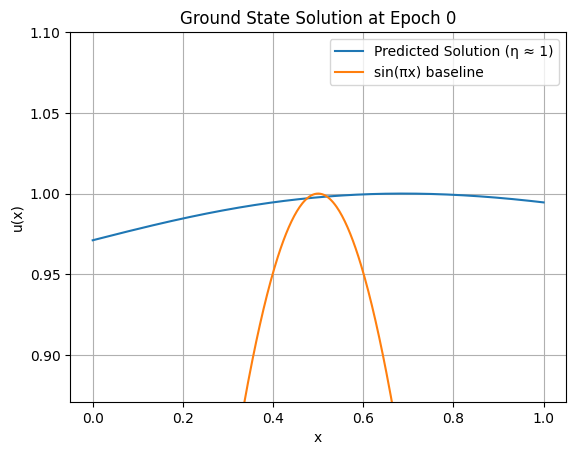

Epoch 0: Loss = 1.00053e+03, Rayleigh Quotient λ = 0.01427


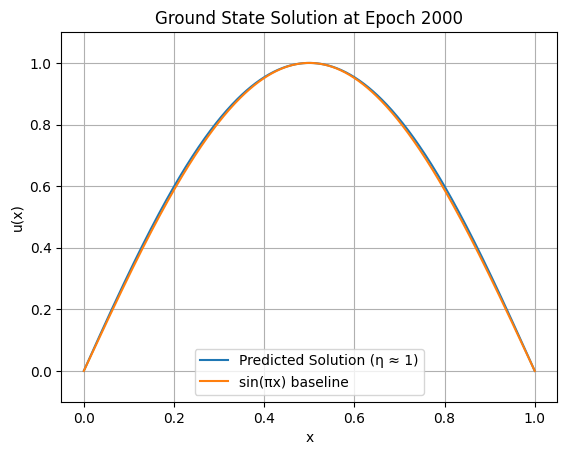

Epoch 2000: Loss = 1.20170e+01, Rayleigh Quotient λ = 10.65481


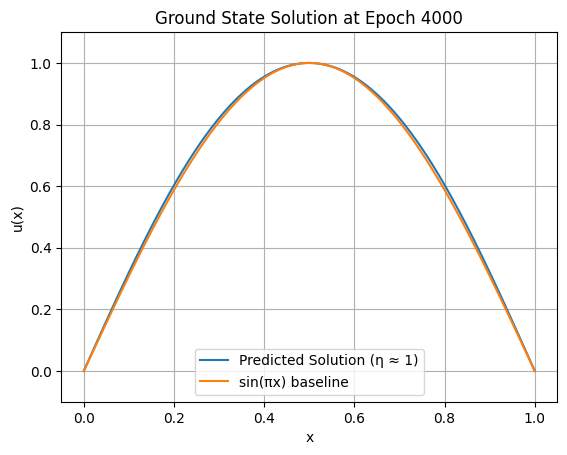

Epoch 4000: Loss = 1.18799e+01, Rayleigh Quotient λ = 10.67208


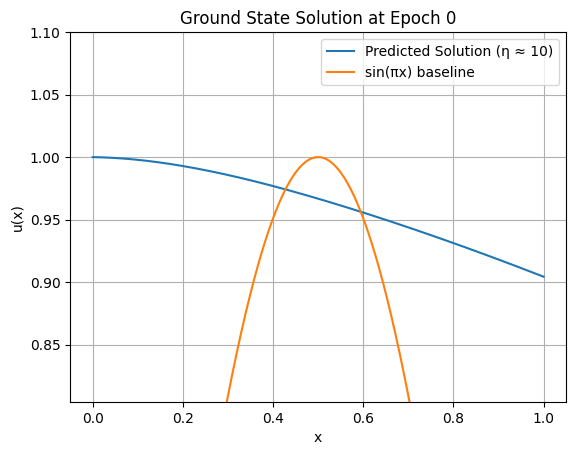

Epoch 0: Loss = 1.00309e+03, Rayleigh Quotient λ = 0.35891


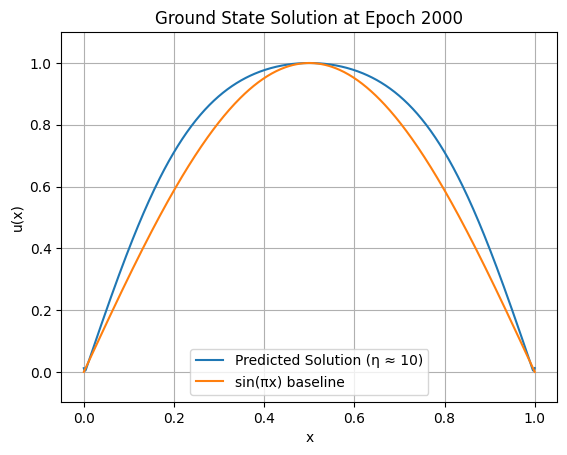

Epoch 2000: Loss = 8.15803e+01, Rayleigh Quotient λ = 16.70537


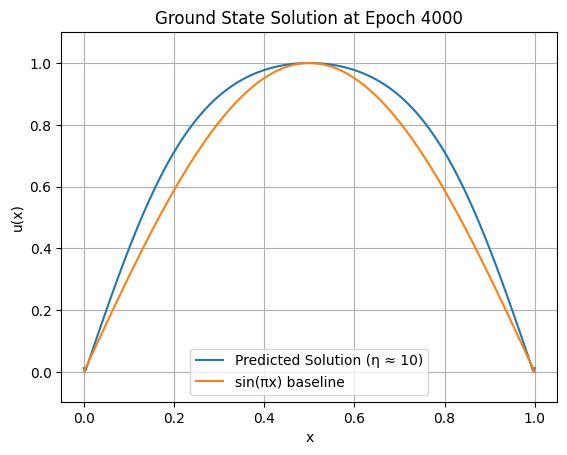

Epoch 4000: Loss = 8.15632e+01, Rayleigh Quotient λ = 16.70721


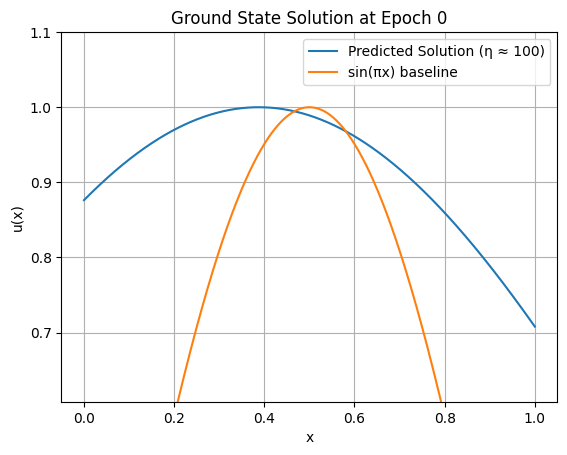

Epoch 0: Loss = 1.01420e+03, Rayleigh Quotient λ = 14.19859


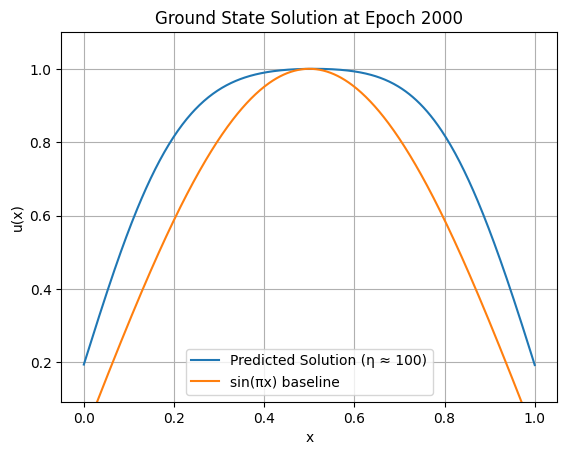

Epoch 2000: Loss = 7.95418e+02, Rayleigh Quotient λ = 17.22569


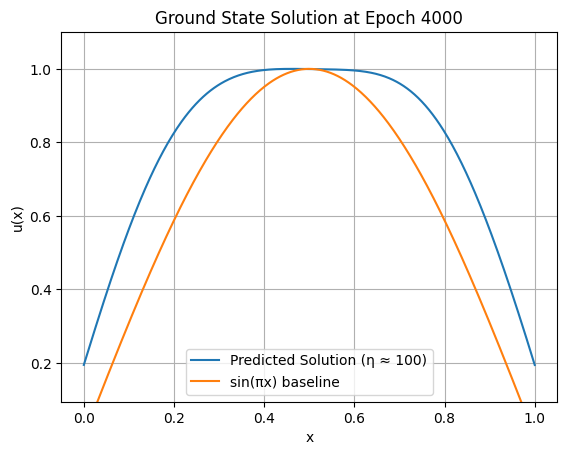

Epoch 4000: Loss = 7.95191e+02, Rayleigh Quotient λ = 17.28681


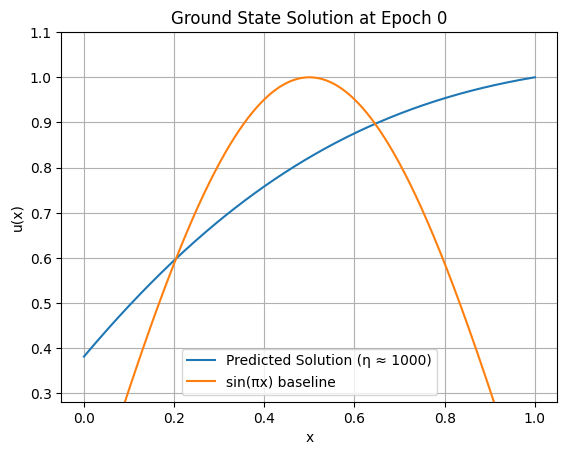

Epoch 0: Loss = 1.00517e+03, Rayleigh Quotient λ = 4.53582


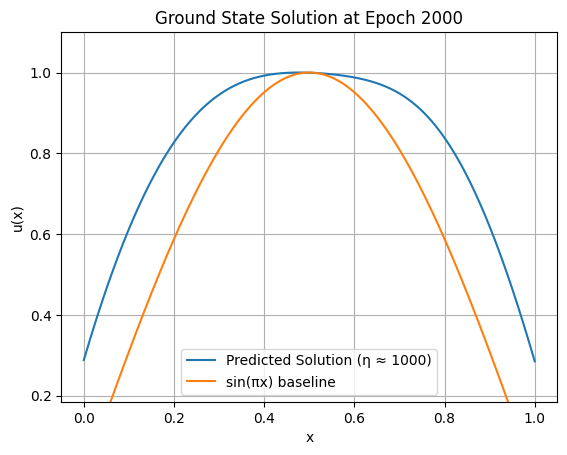

Epoch 2000: Loss = 9.84844e+02, Rayleigh Quotient λ = 19.79272


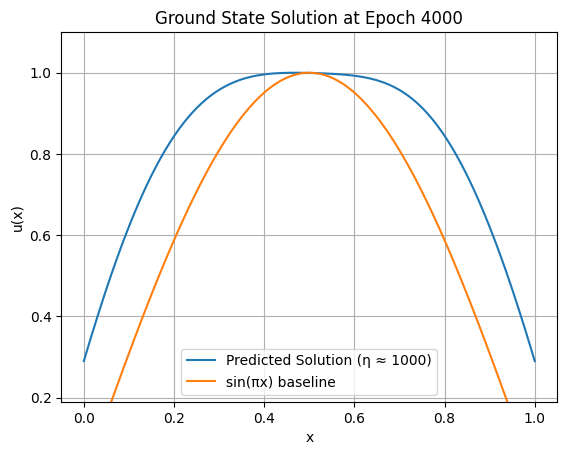

Epoch 4000: Loss = 9.84741e+02, Rayleigh Quotient λ = 19.62593


In [2]:
# Training configuration
N_train = 500
x_train = torch.linspace(0, 1, N_train).view(-1, 1).to(device)

models = [PINN().to(device) for _ in range(4)]
etas = [1, 10, 100, 1000]
Bs = [2000, 2000, 2000, 2000]
Ns = [1000, 1000, 1000, 1000]
epochs_list = [4001, 4001, 4001, 4001]

for model, eta, B, N, epochs in zip(models, etas, Bs, Ns, epochs_list):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, x_train, epochs, optimizer, eta, B, N)

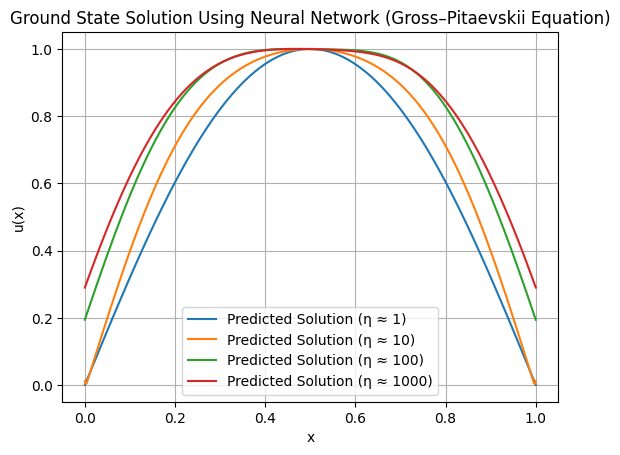

In [3]:
# Final plot of the predicted solution
for model, eta in zip(models, etas):
    with torch.no_grad():
        u_pred = model(x_train).cpu().numpy()
        u_pred = np.abs(u_pred) / np.max(np.abs(u_pred))
        plt.plot(x_train.cpu().numpy(), u_pred, label=f'Predicted Solution (η ≈ {eta})')

plt.title('Ground State Solution Using Neural Network (Gross–Pitaevskii Equation)')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.grid(True)
plt.legend()
plt.show()